
## План семинара

* Знакомство
* Организационные вопросы
* Структура семинара
* По следам лекции MLP
* Блиц
* Вместо домашки


#  Данные

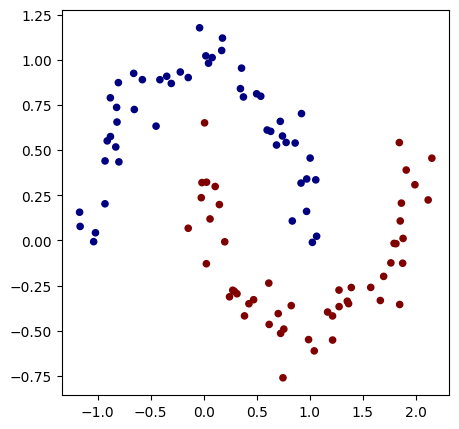

In [ ]:
import numpy as np

from sklearn.datasets import make_moons, make_blobs
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=100, noise=0.1, random_state=1)

plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')



# Torch MLP

## Определяем модель

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# initialize a model
class MLP(nn.Module):
    def __init__(self, activation_cls=nn.Sigmoid):
        super().__init__()

        self.input_layer  = nn.Linear(2, 100)
        self.hidden_layer = nn.Linear(100, 100)
        self.output_layer = nn.Linear(100, 1)
        self.activation   = activation_cls()

        return

    def forward(self, x_coordinates):
        # x_coordinates ~ [ batch_size, 2 ]

        latents = self.activation(self.input_layer(x_coordinates)) # [ batch_size, 100 ]
        latents = self.activation(self.hidden_layer(latents))      # [ batch_size, 100 ]
        scores = self.output_layer(latents)                        # [ batch_size, 1 ]
        scores = scores[:, 0]                                      # [ batch_size ]

        return scores


model = MLP()
print(model)
print("number of parameters", sum(p.numel() for p in model.parameters()))


MLP(
  (input_layer): Linear(in_features=2, out_features=100, bias=True)
  (hidden_layer): Linear(in_features=100, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (activation): Sigmoid()
)
number of parameters 10501


In [ ]:
print("Parameters shapes:")
print([p.shape for p in model.hidden_layer.parameters()])

Parameters shapes:
[torch.Size([100, 100]), torch.Size([100])]


In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1964,  0.4546],
         [-0.4678,  0.0844],
         [-0.4692, -0.6855],
         [ 0.2728,  0.2529],
         [ 0.5003, -0.5070],
         [ 0.2435,  0.3507],
         [-0.1660, -0.0416],
         [-0.2565, -0.5397],
         [ 0.4089,  0.6083],
         [ 0.1863,  0.5470],
         [-0.5833, -0.3992],
         [ 0.6319,  0.2666],
         [ 0.6118, -0.3667],
         [-0.6403,  0.0018],
         [ 0.5715, -0.6392],
         [-0.3263, -0.6783],
         [-0.1357, -0.4748],
         [ 0.0809, -0.6625],
         [-0.2061, -0.4014],
         [-0.1698, -0.6366],
         [-0.5729,  0.1135],
         [-0.4400, -0.1222],
         [ 0.5949,  0.3673],
         [ 0.3460, -0.0854],
         [-0.1259, -0.2238],
         [ 0.4546, -0.6911],
         [-0.0024,  0.5259],
         [ 0.5028, -0.1445],
         [ 0.3702,  0.5472],
         [ 0.2612,  0.2442],
         [ 0.5121, -0.5681],
         [-0.5781, -0.0511],
         [ 0.1269,  0.6358],
         [-0.3511,  

## Вычисляем лосс

In [ ]:

# loss function
def loss(model, Xbatch, ybatch):

    Xbatch = torch.tensor(Xbatch).float() # [ batch_size, 2 ]

    # ybatch.max() == 1, ybatch.min() == -1
    ybatch = torch.tensor(ybatch).float() # [ batch_size ]

    # forward the model to get scores
    model_prediction = model.forward(Xbatch) # [ batch_size, 1 ]

    # svm "max-margin" loss
    losses = F.relu(1 - ybatch * model_prediction) # [ batch_size ]
    loss = losses.mean()

    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p).sum() for p in model.parameters())
    total_loss = loss + reg_loss

    # also get accuracy
    accuracy = ((ybatch > 0) == (model_prediction > 0)).float().mean()
    return total_loss, accuracy

total_loss, acc = loss(model, X, y)
print(total_loss, acc)

tensor(0.7622, grad_fn=<AddBackward0>) tensor(0.5000)


In [ ]:
# optimization

def train(model, learning_rate=0.1):

    Xbatch, ybatch = make_moons(n_samples=100, noise=0.1, random_state=1)
    ybatch = y * 2 - 1 # make y be -1 or 1

    for k in range(300):

        model.zero_grad() # обнуляем градиенты с предыдущего шага

        # forward
        total_loss, acc = loss(model, Xbatch, ybatch)

        # backward
        total_loss.backward() # вычисляем новые значения градиентов
        # (model.linear_in.weight.grad)

        # шаг оптимизации
        # update (sgd)
        for p in model.parameters():
            p.data = p.data - learning_rate * p.grad

        if k % 50 == 0:
            print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


model = MLP()

train(model, learning_rate=0.1)

step 0 loss 1.0069016218185425, accuracy 50.0%
step 50 loss 0.911250650882721, accuracy 50.0%
step 100 loss 0.5568347573280334, accuracy 77.0%
step 150 loss 0.4089655578136444, accuracy 80.0%
step 200 loss 0.3651100993156433, accuracy 84.0%
step 250 loss 0.3334195017814636, accuracy 84.0%


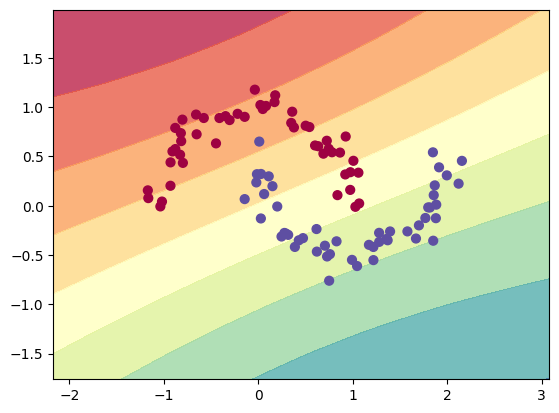

In [ ]:
def visualize_model_prediction(model):

    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]

    if isinstance(model, nn.Module):
        with torch.no_grad():
            Xbatch = torch.tensor(Xmesh).float()

            scores = model.forward(Xbatch)
            Z = scores.numpy()

    else:
        scores = clf.decision_function(Xmesh)
        Z = scores

    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

visualize_model_prediction(model)

## Вклад нелинейностей



step 0 loss 1.0420284271240234, accuracy 42.0%
step 50 loss 0.25818559527397156, accuracy 90.0%
step 100 loss 0.19300152361392975, accuracy 92.0%
step 150 loss 0.10736043751239777, accuracy 96.0%
step 200 loss 0.08910804986953735, accuracy 98.0%
step 250 loss 0.033329494297504425, accuracy 99.0%


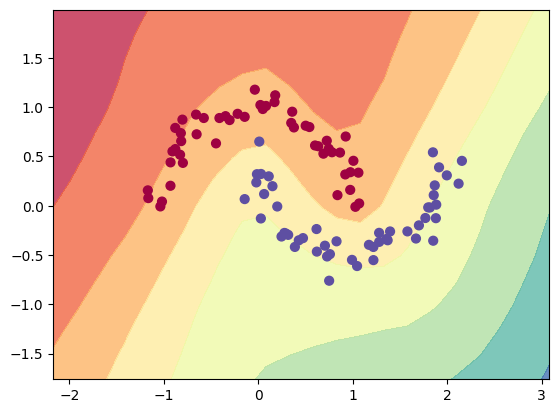

In [ ]:
model = MLP(activation_cls=nn.ReLU)

train(model, learning_rate=0.1)
visualize_model_prediction(model)

step 0 loss 1.0921820402145386, accuracy 15.000000953674316%
step 50 loss 0.2878604829311371, accuracy 87.0%
step 100 loss 0.2876148819923401, accuracy 87.0%
step 150 loss 0.28747209906578064, accuracy 88.0%
step 200 loss 0.28736889362335205, accuracy 87.0%
step 250 loss 0.28738853335380554, accuracy 87.0%


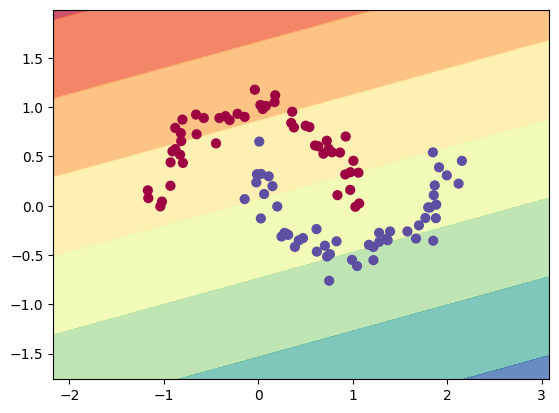

In [ ]:
# nn.Identity(x) == x
model = MLP(activation_cls=nn.Identity)

train(model, learning_rate=0.1)
visualize_model_prediction(model)

# SVM

In [ ]:
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification


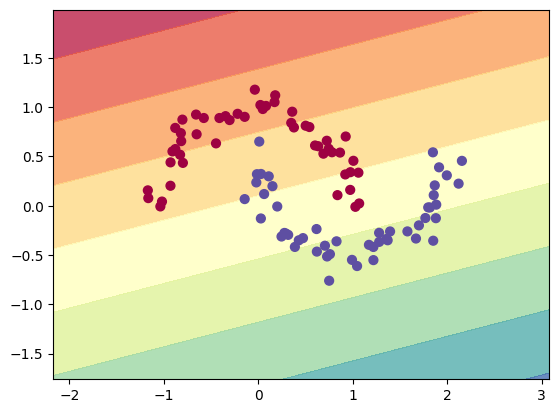

In [ ]:
clf = LinearSVC(random_state=0)
clf.fit(X, y)
visualize_model_prediction(clf)

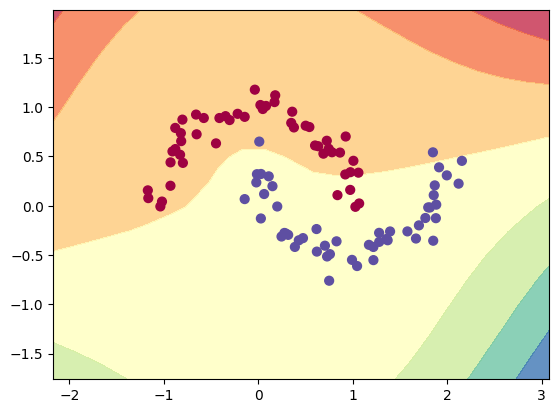

In [ ]:
# визуализация SVM
# https://www.youtube.com/watch?v=OdlNM96sHio

clf = SVC(random_state=0, C=1.0, kernel='poly', degree=3)
clf.fit(X, y)
visualize_model_prediction(clf)

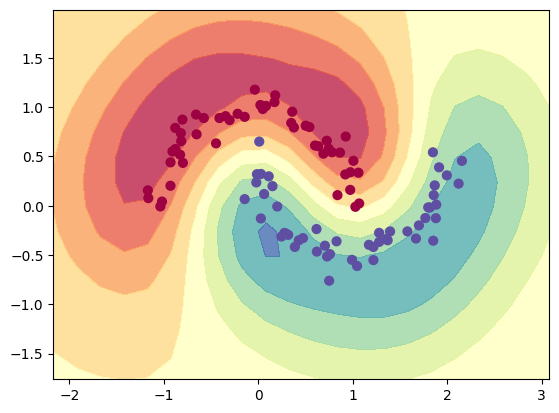

In [ ]:
clf = SVC(random_state=0, C=1.0, kernel='rbf')
clf.fit(X, y)
visualize_model_prediction(clf)

# Батчи и эффективность обучения / инференса

In [ ]:
%%timeit

with torch.no_grad():
    Xbatch = torch.rand([1000, 2])
    model.forward(Xbatch)

915 µs ± 197 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%%timeit

with torch.no_grad():
    Xbatch = torch.rand([1000, 2])
    for i in range(Xbatch.shape[0]):
        model.forward(Xbatch[i:i+1, :])

81.7 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Блиц

### Как луны может разделить логистическая регрессия?

### Чем наша реализация MLP отличается от LinearSVC?

### Сколько слоев должно быть в MLP?

### Зачем мы оборачиваем данные в `torch.tensor` внутри `def loss`?

### Как `learning_rate` влияет на скорость обучения?

Что будет, если мы сделаем очень маленький `lr = 1e-8`?

Что будет, если мы сделаем очень большой `lr = 1e3`?


### Что будет, если убрать все нелинейности из нашей модели?

### Что сделано неправильно в подсчете accuracy в текущем примере?

### Что такое батч? Почему вычисления в нейросетях батчуются?

<!--
Батч - это набор сэмплов из датасета

Почему используются:
1) При обучении используется, тк полный датасет не поместится в оперативную память / видео-память. Но в теории, чем больше размер батча, тем за меньшее кол-во этапов оптимизации мы должны прийти к оптимуму
2) Для эффективности вычислений. И во время обучения, и во время инфренса (вычисления).

 -->


----

# Вместо домашки


#### Напишите функцию, которая считает количество обучаемых параметров модели

На самом деле, количество параметров можно посчитать даже устно. Не забывайте посчитать`bias`!

In [ ]:
def count_learnable_parameters(model):
    params_count = 0

    # your code

    return params_count

print(model)

assert count_learnable_parameters(model) == 10501

MLP(
  (input_layer): Linear(in_features=2, out_features=100, bias=True)
  (hidden_layer): Linear(in_features=100, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (activation): ReLU()
)


10501

#### Реализуйте класс `MyMLP(num_hidden_layers)` с произвольным количеством скрытых слоев

❗ Для этого вам потребуется [`nn.ModuleList`](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html) или [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)

❓Вопрос для самопроверки:
Нужно ли использовать нелинейности между скрытыми слоями?


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# initialize a model
class MyMLP(nn.Module):
    def __init__(self, num_hidden_layers, activation_cls=nn.ReLU):
        super().__init__()

        self.input_layer = nn.Linear(2, 100)

        # self.hidden_layers # TODO initialize hidden layers `num_hidden_layers`
        raise NotImplemented

        self.output_layer = nn.Linear(100, 1)
        self.activation = activation_cls()

        return

    def forward(self, x_coordinates):
        # x_coordinates ~ [ batch_size, 2 ]

        latents = self.activation(self.input_layer(x_coordinates)) # [ batch_size, 16 ]

        # latents = ... # TODO compute hidden layers latents
        raise NotImplemented

        scores = self.output_layer(latents)  # [ batch_size, 1 ]
        scores = scores[:, 0]                # [ batch_size ]

        return scores


# Если вы все сделали правильно, должны пройти ассерты
model_1_hidden_layer = MyMLP(num_hidden_layers=1)
assert count_learnable_parameters(model_1_hidden_layer) == 10501

assert model_1_hidden_layer.forward(torch.rand(10, 2)).shape == torch.Size([10])

model_2_hidden_layer = MyMLP(num_hidden_layers=2)
assert count_learnable_parameters(model_2_hidden_layer) == 20601

model_3_hidden_layer = MyMLP(num_hidden_layers=3)
assert count_learnable_parameters(model_3_hidden_layer) == 30701


#### Обучите `MyMLP()` с разным количеством скрытых слоев. На задачке moons. Как количество скрытых слоев влияет на качество модели? Подумайте, почему так происходит?

In [ ]:
# training code

# evaluation code
